# Using PyTorch and MONAI for MRI Alzheimer's Classification

In [1]:
import logging
import os
import sys
from tqdm.notebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ImageDataset, decollate_batch
from monai.metrics import ROCAUCMetric
from monai.transforms import Activations, AsDiscrete, AddChannel, Compose, Resize, ScaleIntensity, EnsureType, SpatialCrop, CropForeground, Spacing

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.6.0
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.61.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.0
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# This class allows you to access dictionary items with a dot
# Gathered from here: https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

FLAGS = {
    'shape'       : (128, 128, 128),
    'data_dir'    : '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data',  # use this if on jupyter
    'batch_size'  : 5,
    'random_state': 20,
    'epochs'      : 110
}
FLAGS = dotdict(FLAGS)
print(FLAGS)

{'shape': (128, 128, 128), 'data_dir': '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data', 'batch_size': 5, 'random_state': 20, 'epochs': 110}


In [3]:
from sklearn.utils import shuffle

def generate_filenames(labels=['control', 'dementia']):
    pairs = []
    
    for label in labels:
        label_dir = os.path.join(FLAGS.data_dir, label)
        mr_ids = os.listdir(label_dir)
        mr_ids.sort()
        
        for mr_id in tqdm(mr_ids, desc=label):
            scans = os.path.join(label_dir, mr_id)
            img_file = [file for file in os.listdir(scans) if "nii.gz" in file]
            img_path = os.path.join(scans, img_file[0])
            i = 1 if label == 'dementia' else 0
            pairs.append([img_path, i])
    
    m = len(pairs)
    filenames = []
    labels = np.zeros(m, dtype=np.int64)
    
    idx = 0
    for filename, label in pairs:
        filenames.append(filename)
        labels[idx] = label
        idx += 1
    
    filenames = np.array(filenames)
    filenames, labels = shuffle(filenames, labels, random_state=FLAGS.random_state)
    return filenames, labels
        

X_filenames, y_labels = generate_filenames()

control:   0%|          | 0/712 [00:00<?, ?it/s]

dementia:   0%|          | 0/310 [00:00<?, ?it/s]

In [4]:
# There are two labels: 0 represents control patients, and 1 represents dementia patients
for idx in range(len(X_filenames)):
    if idx < 10:
        print(y_labels[idx], X_filenames[idx])
    dementia = "dementia" in X_filenames[idx]
    label = y_labels[idx]
    if int(dementia) != label:
        print("Bad: ", X_filenames[idx], label)

1 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30040_MR_d2899/OAS30040.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30089_MR_d0001/OAS30089.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30096_MR_d0024/OAS30096.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30197_MR_d0115/OAS30197.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30475_MR_d0062/OAS30475.nii.gz
1 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30948_MR_d0076/OAS30948.nii.gz
1 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30692_MR_d2407/OAS30692.nii.gz
1 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30650_MR_d1879/OAS30650.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30939_MR_d0483/OAS30939.nii.gz
1 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS31084_MR_d2319/OAS31084.nii.gz


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filenames, y_labels, test_size=.25, random_state=FLAGS.random_state, shuffle=True)

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(766,) (256,) (766,) (256,)


In [7]:
from collections import Counter
counter_train = Counter(y_train)
counter_test = Counter(y_test)
print(counter_train, (counter_train[0] / (counter_train[0] + counter_train[1]),
                     (counter_train[1] / (counter_train[0] + counter_train[1]))))
print(counter_test, (counter_test[0] / (counter_test[0] + counter_test[1]),
                     (counter_test[1] / (counter_test[0] + counter_test[1]))))

Counter({0: 531, 1: 235}) (0.6932114882506527, 0.30678851174934724)
Counter({0: 181, 1: 75}) (0.70703125, 0.29296875)


In [8]:
train_files = [{"img": img, "label": label} for img, label in zip(X_train, y_train)]
val_files = [{"img": img, "label": label} for img, label in zip(X_test, y_test)]

In [9]:
# Validate the train and val sets
for image in train_files:
    dementia = "dementia" in image["img"]
    label = image["label"]
    if int(dementia) != label:
        print("Bad: ", image)

for image in val_files:
    dementia = "dementia" in image["img"]
    label = image["label"]
    if int(dementia) != label:
        print("Bad: ", image)
        
print(len(train_files), len(val_files))

766 256


In [10]:
# define transforms
transforms = Compose([ScaleIntensity(), AddChannel(), Resize(FLAGS.shape), SpatialCrop(roi_start=(15, 15, 0), roi_end=(110,110,110)), EnsureType()])

In [11]:
# Define image dataset, data loader
check_ds = ImageDataset(image_files=X_filenames, labels=y_labels, transform=transforms)
check_loader = DataLoader(check_ds, batch_size=FLAGS.batch_size, num_workers=12, pin_memory=torch.cuda.is_available())
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label)

<class 'torch.Tensor'> torch.Size([5, 1, 95, 95, 110]) tensor([1, 0, 0, 0, 0])


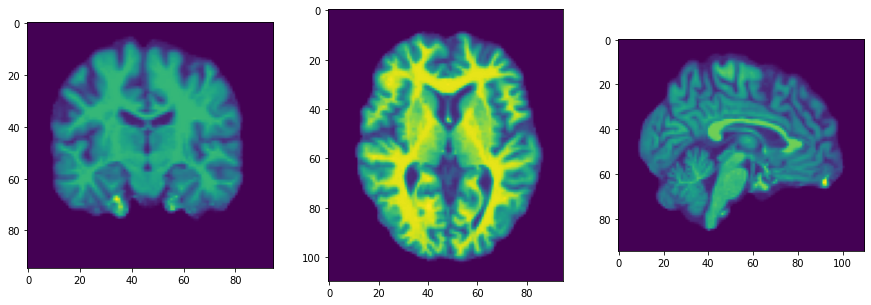

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(np.rot90(im[0, 0, :, :, int(110/2)], 3))
ax[1].imshow(np.rot90(im[0, 0, :, int(95/2), :]))
ax[2].imshow(im[0, 0, int(95/2), :, :])

In [13]:
from IPython import display as dspl
import ipywidgets as widgets

# graphs the MRI image
def show_graph(img, height, width, depth, color, patient):
    # Plots brain scans in all three dimensions
    fig, ax = plt.subplots(1, 3, figsize=(15,7))
    pat_types = ['control', 'dementia']
    print(pat_types[label[patient]])
    print(img.shape)

    ax[0].set_title("height")
    ax[1].set_title("width")
    ax[2].set_title("depth")

    colormap = 'gray' if color == 'Gray' else 'viridis'
    ax[0].imshow(img[patient, 0, height, :, :], cmap=colormap)
    ax[1].imshow(np.rot90(img[patient, 0, :, width, :]), cmap=colormap)
    ax[2].imshow(np.rot90(img[patient, 0, :, :, depth], 3), cmap=colormap)
    

def disp(pat_type, image_data):
    num_pats, _, height, width, depth  = image_data.shape
    co = widgets.ToggleButtons(options=['Gray', 'Color'], description='Color Map')
    hi = widgets.IntSlider(value=height/2, max=height-1, continous_updates=False, description='View 1')
    wi = widgets.IntSlider(value=width/2, max=width-1, continous_updates=False, description='View 2')
    de = widgets.IntSlider(value=depth/2, max=depth-1, continous_updates=False, description='View 3')
    pat = widgets.Dropdown(options=range(num_pats), value=0, description='Patient Number')
    ui = widgets.HBox([hi, wi, de, co, pat])
    
    display_output = widgets.interactive_output(show_graph, {'img':widgets.fixed(image_data),
                                                             'height':hi,
                                                             'width':wi,
                                                             'depth':de,
                                                             'color':co,
                                                             'patient':pat})
    dspl.display(ui, display_output)

disp(label[0], im)

Output()

In [14]:
# create a training data loader
train_ds = ImageDataset(image_files=X_train, labels=y_train, transform=transforms)
train_loader = DataLoader(train_ds, batch_size=FLAGS.batch_size, shuffle=True, num_workers=12)
test_train_loader = DataLoader(train_ds, batch_size=FLAGS.batch_size, num_workers=12)

# create a testing data loader
val_ds = ImageDataset(image_files=X_test, labels=y_test, transform=transforms)
val_loader = DataLoader(val_ds, batch_size=FLAGS.batch_size, num_workers=12)

In [15]:
auc_metric = ROCAUCMetric()
post_pred = Compose([EnsureType(), Activations(softmax=True)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

In [16]:
from trainedmodels.densenet import densenet121

In [17]:
# Create DenseNet121, CrossEntropyLoss and SGD optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = densenet121(channels=1, num_classes=2, drop_rate=0.7).to(device)
model = torch.nn.DataParallel(model).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=False)

cuda


In [18]:
def lr_scheduler(optimizer, epoch, initial_lr=0.1, lr_decay=0.1, last_step=80):
    """Decay learning rate by lr_decay on predefined epochs"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = initial_lr * lr_decay ** (epoch/last_step)
    return optimizer

In [19]:
!rm -rf runs

In [20]:
def get_test_predicted(device, model, loader):
    predicted = torch.tensor([], dtype=torch.float32, device=device)
    actual = torch.tensor([], dtype=torch.long, device=device)
    
    with torch.no_grad():
    # Loop through validation data and get predictions
        for iteration, data in enumerate(loader):
            print(f'Reading validation set: {iteration+1}/{len(loader)}', end='\r')
            images, labels = data
            labels = labels.to(device)
            
            outputs = model(images)
            
            predicted = torch.cat([predicted, outputs], dim=0)
            actual = torch.cat([actual, labels], dim=0)
    
    return actual, predicted

Epochs:   0%|          | 0/110 [00:00<?, ?it/s]

----------
epoch 1/110
current lr: 0.1


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 1 average loss: 1.8976
>>> Validation set
Sample | raw prediction: tensor([ 0.7419, -0.7899]), prediction: 0, actual: 1
saved new best metric model


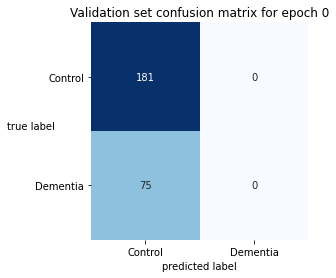

epoch: 1, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3708, precision: 0.0000, recall: 0.0000
best epoch: 1, best accuracy: 0.5
----------
epoch 2/110
current lr: 0.09716279515771062


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 2 average loss: 0.6833
>>> Validation set
Sample | raw prediction: tensor([ 0.2730, -0.3264]), prediction: 0, actual: 1


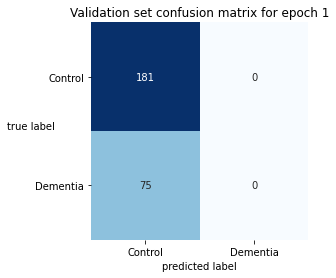

epoch: 2, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6309, precision: 0.0000, recall: 0.0000
best epoch: 1, best accuracy: 0.5
----------
epoch 3/110
current lr: 0.09440608762859234


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 3 average loss: 0.5988
>>> Validation set
Sample | raw prediction: tensor([ 0.5107, -0.5661]), prediction: 0, actual: 1


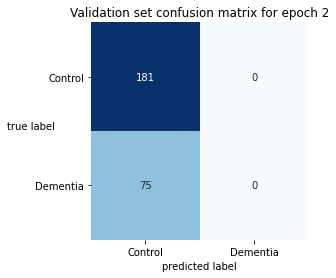

epoch: 3, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4354, precision: 0.0000, recall: 0.0000
best epoch: 1, best accuracy: 0.5
----------
epoch 4/110
current lr: 0.09172759353897797


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 4 average loss: 0.6131
>>> Validation set
Sample | raw prediction: tensor([ 0.3240, -0.3526]), prediction: 0, actual: 1


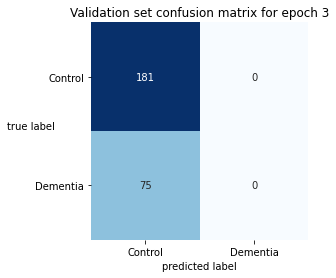

epoch: 4, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7519, precision: 0.0000, recall: 0.0000
best epoch: 1, best accuracy: 0.5
----------
epoch 5/110
current lr: 0.08912509381337456


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 5 average loss: 0.6024
>>> Validation set
Sample | raw prediction: tensor([ 0.6309, -0.6453]), prediction: 0, actual: 1


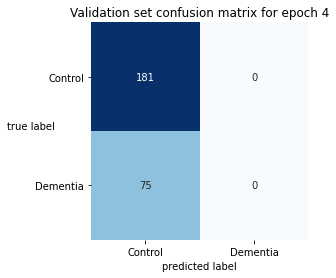

epoch: 5, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7408, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 0.3565, -0.3726]), prediction: 0, actual: 1


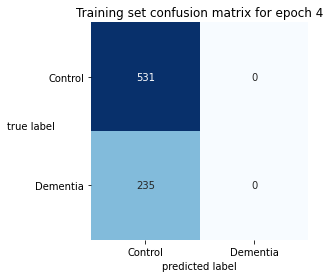

epoch: 5, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.6870, precision: 0.0000, recall: 0.0000
best epoch: 1, best accuracy: 0.5
----------
epoch 6/110
current lr: 0.08659643233600654


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 6 average loss: 0.5921
>>> Validation set
Sample | raw prediction: tensor([ 0.4312, -0.4569]), prediction: 0, actual: 1


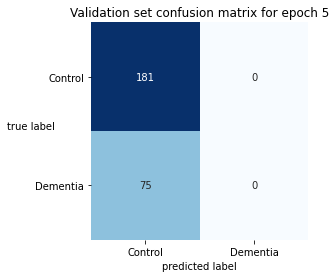

epoch: 6, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7912, precision: 0.0000, recall: 0.0000
best epoch: 1, best accuracy: 0.5
----------
epoch 7/110
current lr: 0.08413951416451952


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 7 average loss: 0.6058
>>> Validation set
Sample | raw prediction: tensor([ 0.1470, -0.1573]), prediction: 0, actual: 1
saved new best metric model


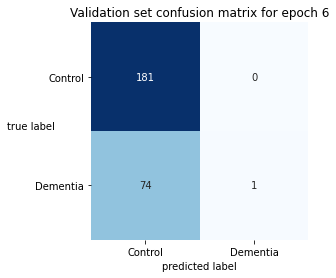

epoch: 7, accuracy: 0.7109, balanced_acc: 0.5067, AUC: 0.7834, precision: 1.0000, recall: 0.0133
best epoch: 7, best accuracy: 0.5066666666666667
----------
epoch 8/110
current lr: 0.081752303794365


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 8 average loss: 0.5755
>>> Validation set
Sample | raw prediction: tensor([ 2.4920, -2.4616]), prediction: 0, actual: 1


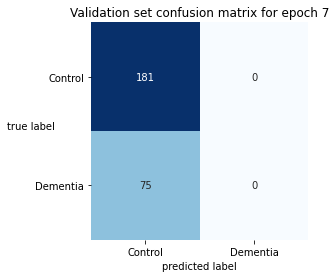

epoch: 8, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6361, precision: 0.0000, recall: 0.0000
best epoch: 7, best accuracy: 0.5066666666666667
----------
epoch 9/110
current lr: 0.07943282347242815


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 9 average loss: 0.6084
>>> Validation set
Sample | raw prediction: tensor([ 0.4484, -0.4468]), prediction: 0, actual: 1


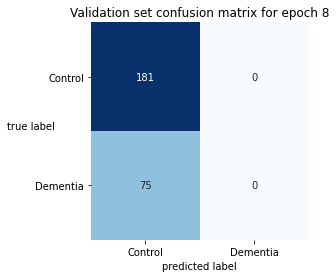

epoch: 9, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7876, precision: 0.0000, recall: 0.0000
best epoch: 7, best accuracy: 0.5066666666666667
----------
epoch 10/110
current lr: 0.07717915155850125


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 10 average loss: 0.5639
>>> Validation set
Sample | raw prediction: tensor([ 0.0111, -0.0048]), prediction: 0, actual: 1
saved new best metric model


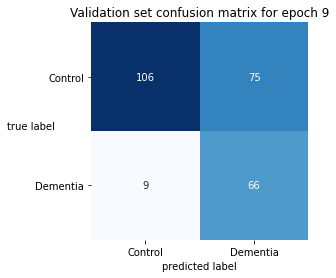

epoch: 10, accuracy: 0.6719, balanced_acc: 0.7328, AUC: 0.7629, precision: 0.4681, recall: 0.8800
>>> Train set
Sample | raw prediction: tensor([-0.0479,  0.0446]), prediction: 1, actual: 1


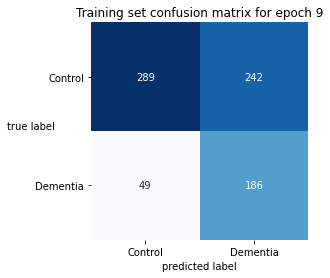

epoch: 10, accuracy: 0.6201, balanced_acc: 0.6679, AUC: 0.7251, precision: 0.4346, recall: 0.7915
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 11/110
current lr: 0.07498942093324559


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 11 average loss: 0.5563
>>> Validation set
Sample | raw prediction: tensor([ 0.1051, -0.1204]), prediction: 0, actual: 1


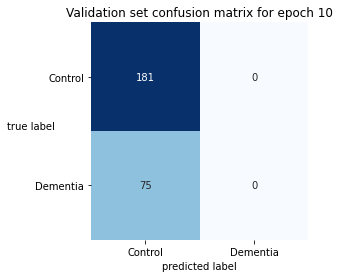

epoch: 11, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3996, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 12/110
current lr: 0.07286181745132278


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 12 average loss: 0.5629
>>> Validation set
Sample | raw prediction: tensor([-0.1993,  0.1875]), prediction: 1, actual: 1


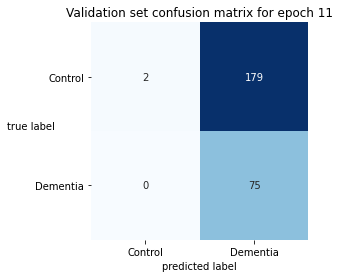

epoch: 12, accuracy: 0.3008, balanced_acc: 0.5055, AUC: 0.6511, precision: 0.2953, recall: 1.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 13/110
current lr: 0.07079457843841379


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 13 average loss: 0.5692
>>> Validation set
Sample | raw prediction: tensor([ 0.2417, -0.2414]), prediction: 0, actual: 1


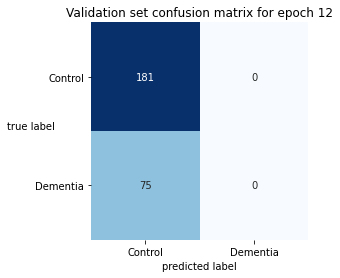

epoch: 13, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7074, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 14/110
current lr: 0.06878599123088076


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 14 average loss: 0.5540
>>> Validation set
Sample | raw prediction: tensor([ 0.2838, -0.2786]), prediction: 0, actual: 1


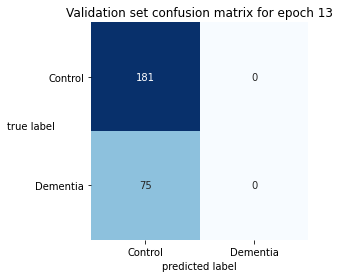

epoch: 14, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7246, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 15/110
current lr: 0.06683439175686147


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 15 average loss: 0.5621
>>> Validation set
Sample | raw prediction: tensor([ 0.1106, -0.1079]), prediction: 0, actual: 1


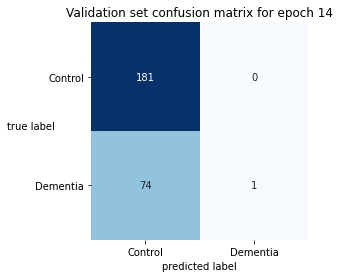

epoch: 15, accuracy: 0.7109, balanced_acc: 0.5067, AUC: 0.7447, precision: 1.0000, recall: 0.0133
>>> Train set
Sample | raw prediction: tensor([ 0.0927, -0.0984]), prediction: 0, actual: 1


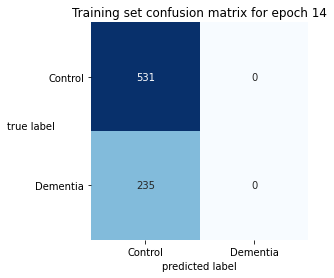

epoch: 15, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7156, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 16/110
current lr: 0.06493816315762113


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 16 average loss: 0.5546
>>> Validation set
Sample | raw prediction: tensor([ 0.7843, -0.7861]), prediction: 0, actual: 1


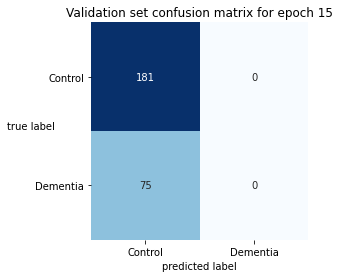

epoch: 16, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7899, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 17/110
current lr: 0.06309573444801933


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 17 average loss: 0.5528
>>> Validation set
Sample | raw prediction: tensor([ 0.3371, -0.3409]), prediction: 0, actual: 1


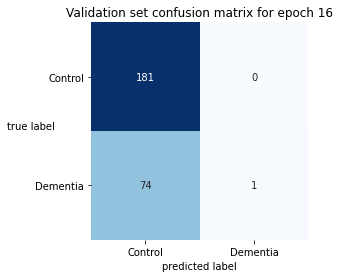

epoch: 17, accuracy: 0.7109, balanced_acc: 0.5067, AUC: 0.7493, precision: 1.0000, recall: 0.0133
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 18/110
current lr: 0.06130557921498208


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 18 average loss: 0.5574
>>> Validation set
Sample | raw prediction: tensor([ 0.0632, -0.0596]), prediction: 0, actual: 1


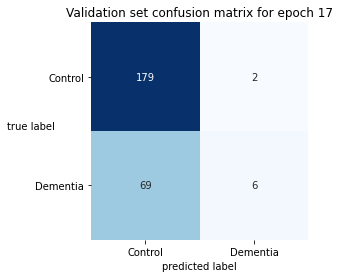

epoch: 18, accuracy: 0.7227, balanced_acc: 0.5345, AUC: 0.7788, precision: 0.7500, recall: 0.0800
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 19/110
current lr: 0.05956621435290105


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 19 average loss: 0.5486
>>> Validation set
Sample | raw prediction: tensor([ 0.6316, -0.6250]), prediction: 0, actual: 1


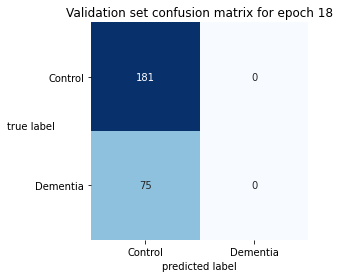

epoch: 19, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7896, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 20/110
current lr: 0.05787619883491207


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 20 average loss: 0.5285
>>> Validation set
Sample | raw prediction: tensor([ 0.1394, -0.1337]), prediction: 0, actual: 1


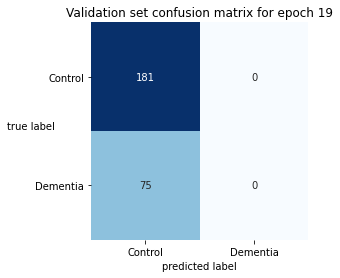

epoch: 20, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7798, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 0.0964, -0.0986]), prediction: 0, actual: 1


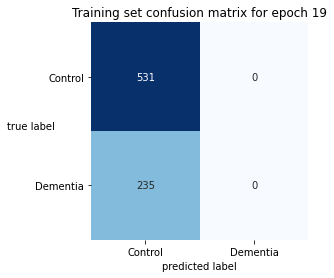

epoch: 20, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7377, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 21/110
current lr: 0.05623413251903491


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 21 average loss: 0.5535
>>> Validation set
Sample | raw prediction: tensor([ 0.7920, -0.7907]), prediction: 0, actual: 1


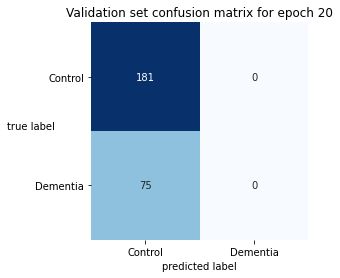

epoch: 21, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7745, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 22/110
current lr: 0.054638654988185424


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 22 average loss: 0.5607
>>> Validation set
Sample | raw prediction: tensor([ 0.6011, -0.5978]), prediction: 0, actual: 1


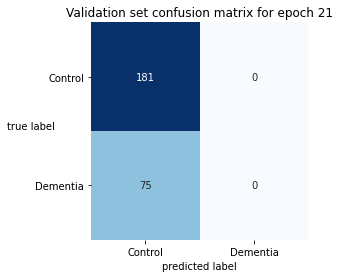

epoch: 22, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7999, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 23/110
current lr: 0.05308844442309884


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 23 average loss: 0.5421
>>> Validation set
Sample | raw prediction: tensor([ 0.5602, -0.5633]), prediction: 0, actual: 1


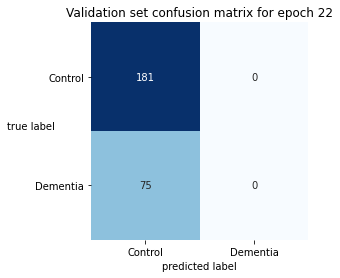

epoch: 23, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7737, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 24/110
current lr: 0.05158221650723058


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 24 average loss: 0.5713
>>> Validation set
Sample | raw prediction: tensor([ 0.5025, -0.5120]), prediction: 0, actual: 1


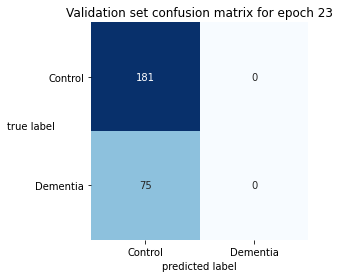

epoch: 24, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7486, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 25/110
current lr: 0.05011872336272724


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 25 average loss: 0.5346
>>> Validation set
Sample | raw prediction: tensor([ 0.3777, -0.3798]), prediction: 0, actual: 1


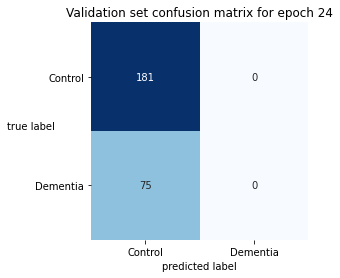

epoch: 25, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7967, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 0.2715, -0.2770]), prediction: 0, actual: 1


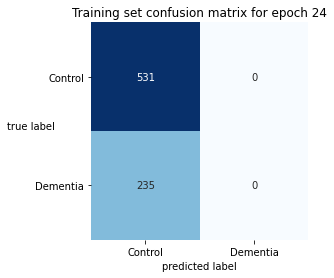

epoch: 25, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7624, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 26/110
current lr: 0.04869675251658631


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 26 average loss: 0.5398
>>> Validation set
Sample | raw prediction: tensor([ 0.4792, -0.4729]), prediction: 0, actual: 1


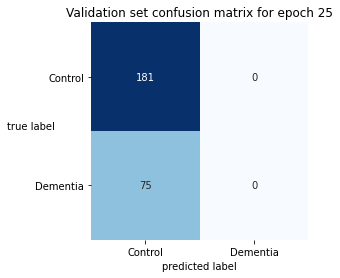

epoch: 26, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7776, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 27/110
current lr: 0.04731512589614805


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 27 average loss: 0.5407
>>> Validation set
Sample | raw prediction: tensor([ 0.3814, -0.3704]), prediction: 0, actual: 1


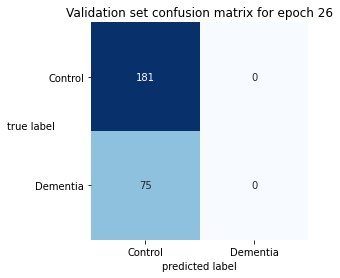

epoch: 27, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7935, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 28/110
current lr: 0.04597269885308722


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 28 average loss: 0.5421
>>> Validation set
Sample | raw prediction: tensor([ 0.1492, -0.1604]), prediction: 0, actual: 1


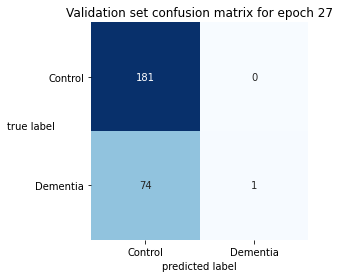

epoch: 28, accuracy: 0.7109, balanced_acc: 0.5067, AUC: 0.7721, precision: 1.0000, recall: 0.0133
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 29/110
current lr: 0.04466835921509632


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 29 average loss: 0.5154
>>> Validation set
Sample | raw prediction: tensor([ 0.5154, -0.5196]), prediction: 0, actual: 1


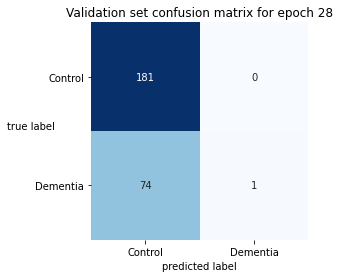

epoch: 29, accuracy: 0.7109, balanced_acc: 0.5067, AUC: 0.7599, precision: 1.0000, recall: 0.0133
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 30/110
current lr: 0.04340102636447439


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 30 average loss: 0.5159
>>> Validation set
Sample | raw prediction: tensor([ 0.6870, -0.6963]), prediction: 0, actual: 1


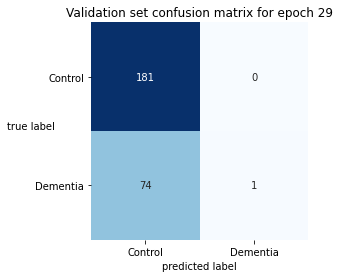

epoch: 30, accuracy: 0.7109, balanced_acc: 0.5067, AUC: 0.7657, precision: 1.0000, recall: 0.0133
>>> Train set
Sample | raw prediction: tensor([ 0.6246, -0.6391]), prediction: 0, actual: 1


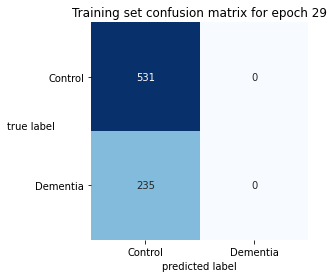

epoch: 30, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7578, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 31/110
current lr: 0.04216965034285823


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 31 average loss: 0.5329
>>> Validation set
Sample | raw prediction: tensor([ 0.5974, -0.5928]), prediction: 0, actual: 1


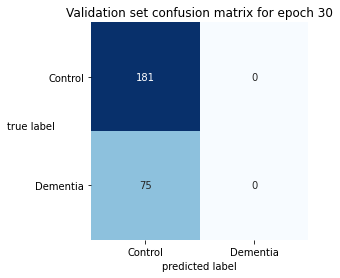

epoch: 31, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7331, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 32/110
current lr: 0.040973210981354154


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 32 average loss: 0.5260
>>> Validation set
Sample | raw prediction: tensor([ 1.2391, -1.2258]), prediction: 0, actual: 1


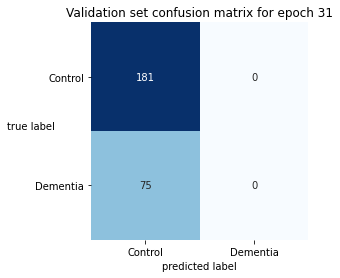

epoch: 32, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7823, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 33/110
current lr: 0.03981071705534973


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 33 average loss: 0.5001
>>> Validation set
Sample | raw prediction: tensor([ 0.7215, -0.7168]), prediction: 0, actual: 1


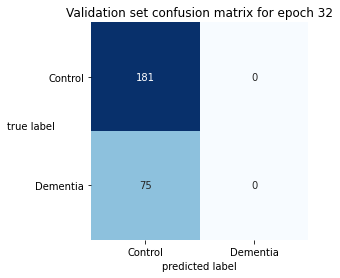

epoch: 33, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7682, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 34/110
current lr: 0.038681205463305224


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 34 average loss: 0.5272
>>> Validation set
Sample | raw prediction: tensor([ 0.4455, -0.4386]), prediction: 0, actual: 1


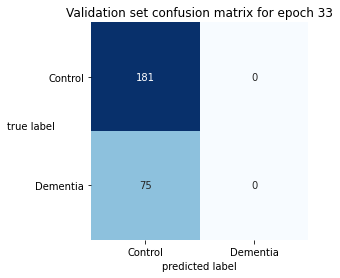

epoch: 34, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7608, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 35/110
current lr: 0.03758374042884442


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 35 average loss: 0.5378
>>> Validation set
Sample | raw prediction: tensor([ 0.6373, -0.6353]), prediction: 0, actual: 1


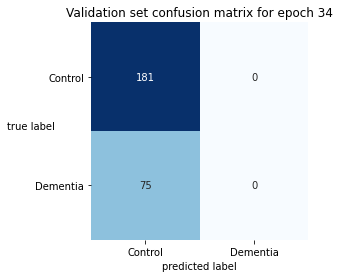

epoch: 35, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7837, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 0.4305, -0.4346]), prediction: 0, actual: 1


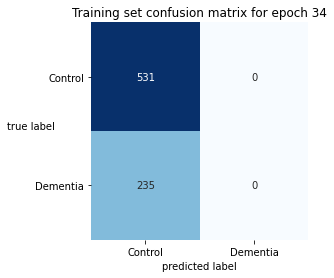

epoch: 35, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7443, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 36/110
current lr: 0.036517412725483776


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 36 average loss: 0.5126
>>> Validation set
Sample | raw prediction: tensor([ 0.7761, -0.7718]), prediction: 0, actual: 1


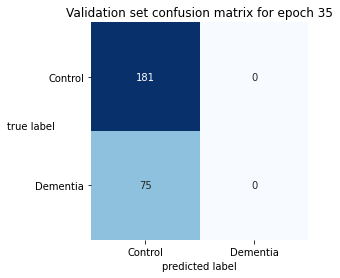

epoch: 36, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7780, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 37/110
current lr: 0.03548133892335755


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 37 average loss: 0.5102
>>> Validation set
Sample | raw prediction: tensor([ 1.1964, -1.1811]), prediction: 0, actual: 1


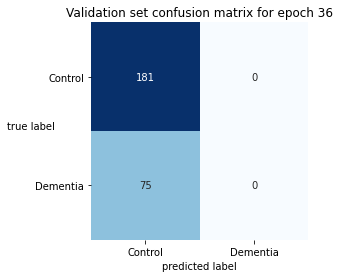

epoch: 37, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7809, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 38/110
current lr: 0.034474660657314936


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 38 average loss: 0.5027
>>> Validation set
Sample | raw prediction: tensor([ 0.3610, -0.3625]), prediction: 0, actual: 1


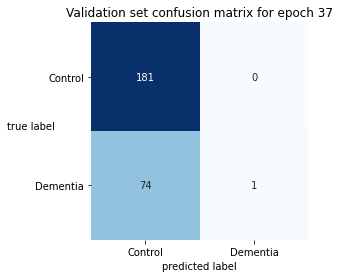

epoch: 38, accuracy: 0.7109, balanced_acc: 0.5067, AUC: 0.6336, precision: 1.0000, recall: 0.0133
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 39/110
current lr: 0.033496543915782766


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 39 average loss: 0.5218
>>> Validation set
Sample | raw prediction: tensor([ 0.7623, -0.7549]), prediction: 0, actual: 1


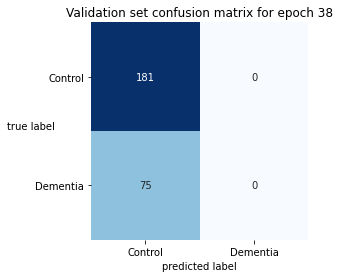

epoch: 39, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6962, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 40/110
current lr: 0.03254617834980459


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 40 average loss: 0.5149
>>> Validation set
Sample | raw prediction: tensor([ 0.9786, -0.9674]), prediction: 0, actual: 1


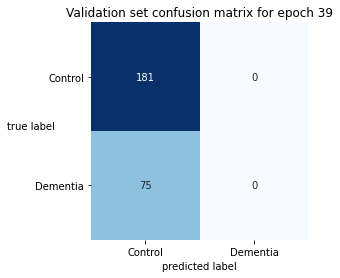

epoch: 40, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7686, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 0.7211, -0.7156]), prediction: 0, actual: 1


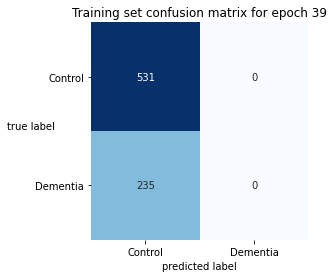

epoch: 40, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7502, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 41/110
current lr: 0.0316227766016838


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 41 average loss: 0.5170
>>> Validation set
Sample | raw prediction: tensor([ 0.8521, -0.8431]), prediction: 0, actual: 1


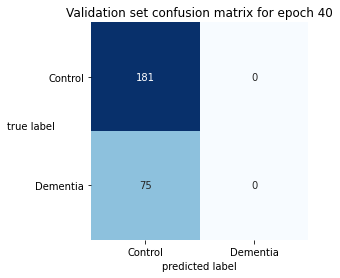

epoch: 41, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7740, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 42/110
current lr: 0.030725573652674473


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 42 average loss: 0.5134
>>> Validation set
Sample | raw prediction: tensor([ 0.7515, -0.7440]), prediction: 0, actual: 1


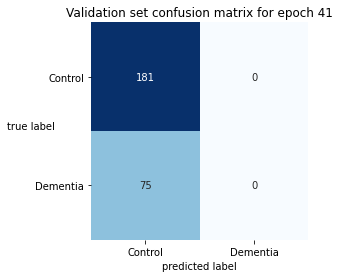

epoch: 42, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7472, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 43/110
current lr: 0.029853826189179596


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 43 average loss: 0.5109
>>> Validation set
Sample | raw prediction: tensor([ 1.2599, -1.2412]), prediction: 0, actual: 1


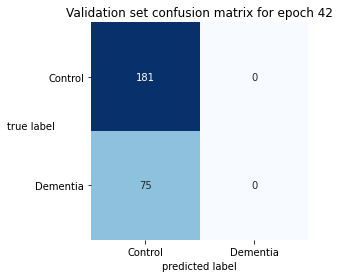

epoch: 43, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7679, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 44/110
current lr: 0.029006811986931544


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 44 average loss: 0.5144
>>> Validation set
Sample | raw prediction: tensor([ 0.7824, -0.7753]), prediction: 0, actual: 1


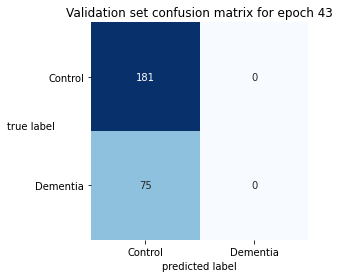

epoch: 44, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6339, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 45/110
current lr: 0.02818382931264454


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 45 average loss: 0.5098
>>> Validation set
Sample | raw prediction: tensor([ 1.2604, -1.2455]), prediction: 0, actual: 1


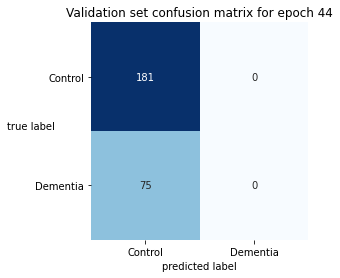

epoch: 45, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7839, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 0.9323, -0.9266]), prediction: 0, actual: 1


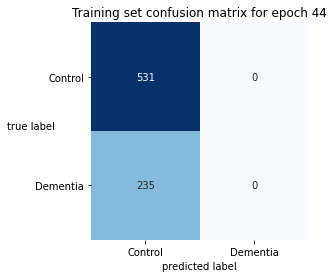

epoch: 45, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7565, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 46/110
current lr: 0.027384196342643614


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 46 average loss: 0.5019
>>> Validation set
Sample | raw prediction: tensor([ 0.6356, -0.6396]), prediction: 0, actual: 1


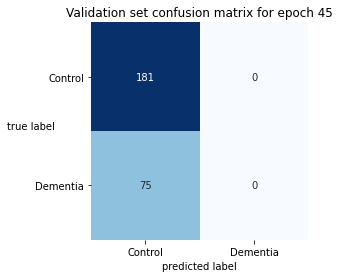

epoch: 46, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4277, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 47/110
current lr: 0.026607250597988102


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 47 average loss: 0.4930
>>> Validation set
Sample | raw prediction: tensor([ 1.0423, -1.0312]), prediction: 0, actual: 1


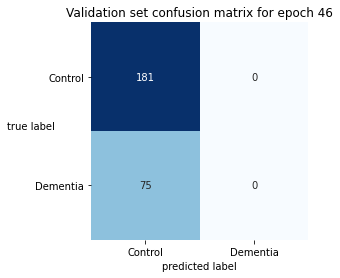

epoch: 47, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6689, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 48/110
current lr: 0.025852348395621907


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 48 average loss: 0.4932
>>> Validation set
Sample | raw prediction: tensor([ 0.9568, -0.9438]), prediction: 0, actual: 1


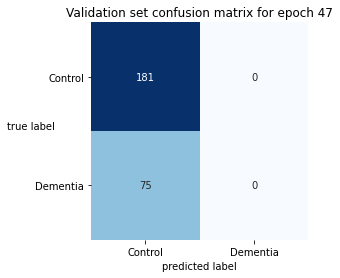

epoch: 48, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3546, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 49/110
current lr: 0.0251188643150958


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 49 average loss: 0.4895
>>> Validation set
Sample | raw prediction: tensor([ 0.7834, -0.7765]), prediction: 0, actual: 1


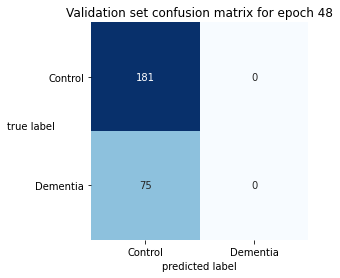

epoch: 49, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.5915, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 50/110
current lr: 0.0244061906804198


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 50 average loss: 0.4972
>>> Validation set
Sample | raw prediction: tensor([ 1.3681, -1.3400]), prediction: 0, actual: 1


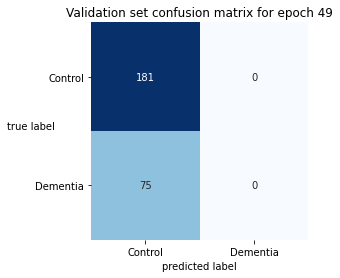

epoch: 50, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6821, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 1.3722, -1.3445]), prediction: 0, actual: 1


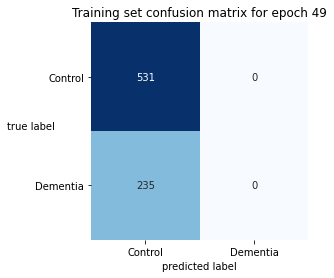

epoch: 50, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7004, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 51/110
current lr: 0.023713737056616557


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 51 average loss: 0.4843
>>> Validation set
Sample | raw prediction: tensor([ 0.7752, -0.7673]), prediction: 0, actual: 1


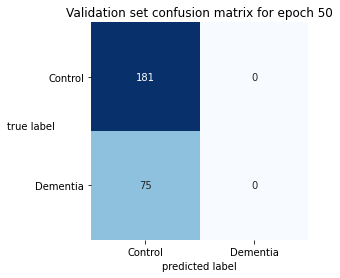

epoch: 51, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6665, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 52/110
current lr: 0.02304092976055846


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 52 average loss: 0.4972
>>> Validation set
Sample | raw prediction: tensor([ 1.1785, -1.1644]), prediction: 0, actual: 1


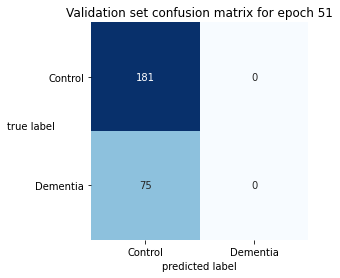

epoch: 52, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6077, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 53/110
current lr: 0.022387211385683396


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 53 average loss: 0.4942
>>> Validation set
Sample | raw prediction: tensor([ 1.2541, -1.2419]), prediction: 0, actual: 1


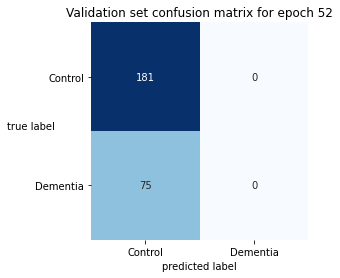

epoch: 53, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7825, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 54/110
current lr: 0.02175204034019523


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 54 average loss: 0.4843
>>> Validation set
Sample | raw prediction: tensor([ 1.8624, -1.8355]), prediction: 0, actual: 1


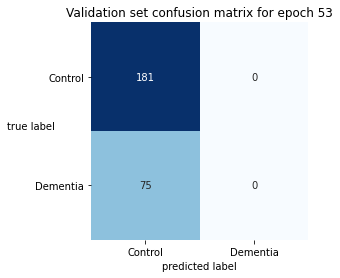

epoch: 54, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7771, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 55/110
current lr: 0.021134890398366468


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 55 average loss: 0.4903
>>> Validation set
Sample | raw prediction: tensor([ 1.1950, -1.1695]), prediction: 0, actual: 1


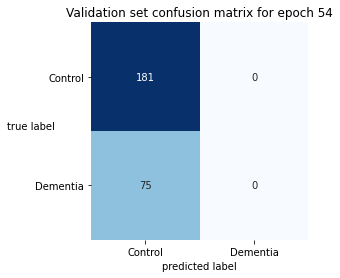

epoch: 55, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4685, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 1.3947, -1.3737]), prediction: 0, actual: 1


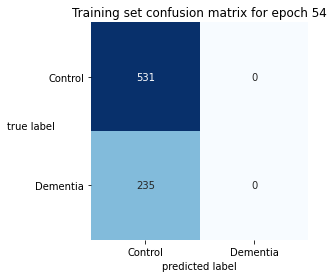

epoch: 55, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.5697, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 56/110
current lr: 0.020535250264571463


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 56 average loss: 0.4940
>>> Validation set
Sample | raw prediction: tensor([ 1.2687, -1.2526]), prediction: 0, actual: 1


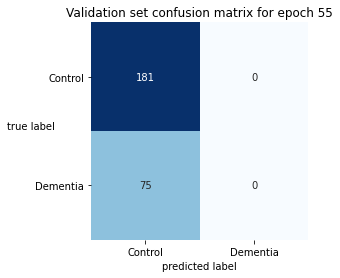

epoch: 56, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4900, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 57/110
current lr: 0.019952623149688802


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 57 average loss: 0.4947
>>> Validation set
Sample | raw prediction: tensor([ 1.3106, -1.2918]), prediction: 0, actual: 1


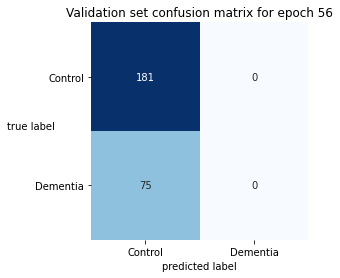

epoch: 57, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6449, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 58/110
current lr: 0.019386526359522073


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 58 average loss: 0.4753
>>> Validation set
Sample | raw prediction: tensor([ 1.5902, -1.5727]), prediction: 0, actual: 1


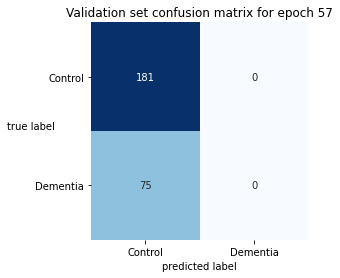

epoch: 58, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6853, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 59/110
current lr: 0.018836490894898007


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 59 average loss: 0.4805
>>> Validation set
Sample | raw prediction: tensor([ 1.5466, -1.5331]), prediction: 0, actual: 1


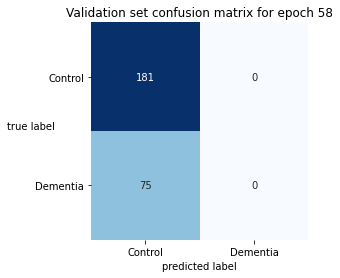

epoch: 59, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3327, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 60/110
current lr: 0.01830206106311056


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 60 average loss: 0.4986
>>> Validation set
Sample | raw prediction: tensor([ 1.9038, -1.8656]), prediction: 0, actual: 1


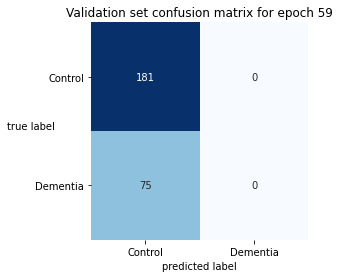

epoch: 60, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6123, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 2.0325, -1.9950]), prediction: 0, actual: 1


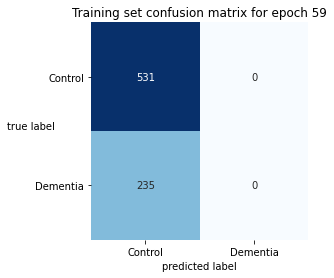

epoch: 60, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.6856, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 61/110
current lr: 0.01778279410038923


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 61 average loss: 0.4784
>>> Validation set
Sample | raw prediction: tensor([ 1.3268, -1.3174]), prediction: 0, actual: 1


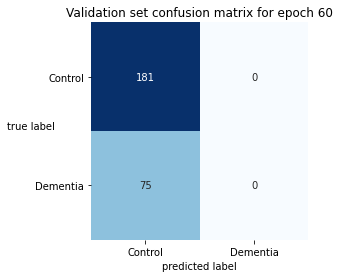

epoch: 61, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.5024, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 62/110
current lr: 0.017278259805078636


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 62 average loss: 0.4645
>>> Validation set
Sample | raw prediction: tensor([ 1.3152, -1.3236]), prediction: 0, actual: 1


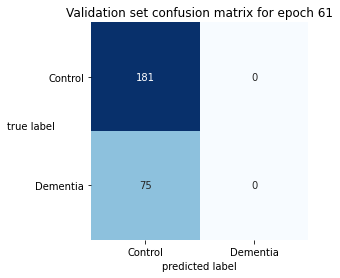

epoch: 62, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4525, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 63/110
current lr: 0.016788040181225605


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 63 average loss: 0.4793
>>> Validation set
Sample | raw prediction: tensor([ 2.2332, -2.2037]), prediction: 0, actual: 1


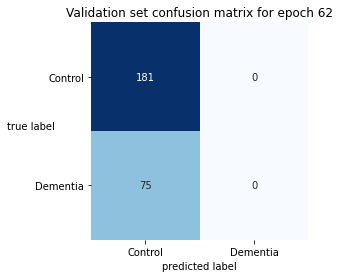

epoch: 63, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7809, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 64/110
current lr: 0.016311729092278387


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 64 average loss: 0.4677
>>> Validation set
Sample | raw prediction: tensor([ 1.6825, -1.6622]), prediction: 0, actual: 1


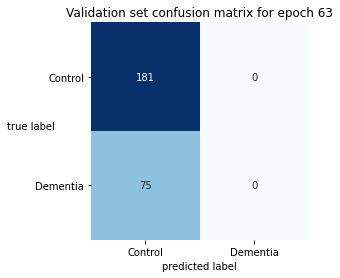

epoch: 64, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7037, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 65/110
current lr: 0.015848931924611134


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 65 average loss: 0.4782
>>> Validation set
Sample | raw prediction: tensor([ 1.6022, -1.5756]), prediction: 0, actual: 1


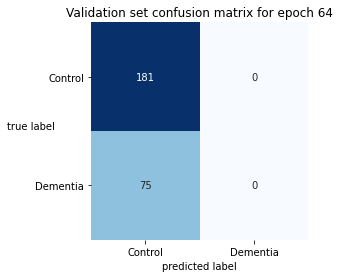

epoch: 65, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7294, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 1.4888, -1.4662]), prediction: 0, actual: 1


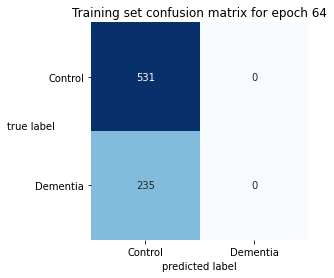

epoch: 65, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7428, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 66/110
current lr: 0.015399265260594923


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 66 average loss: 0.4437
>>> Validation set
Sample | raw prediction: tensor([ 1.7245, -1.7045]), prediction: 0, actual: 1


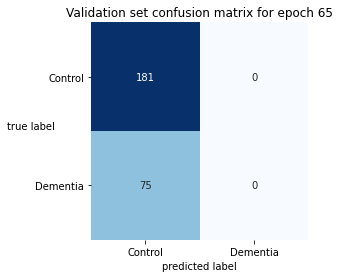

epoch: 66, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6779, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 67/110
current lr: 0.014962356560944337


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 67 average loss: 0.4637
>>> Validation set
Sample | raw prediction: tensor([ 1.8636, -1.8453]), prediction: 0, actual: 1


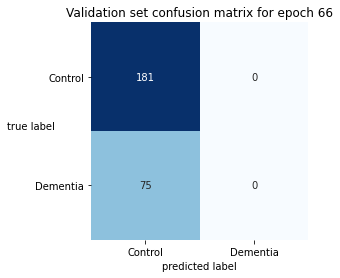

epoch: 67, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6619, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 68/110
current lr: 0.01453784385607662


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 68 average loss: 0.4637
>>> Validation set
Sample | raw prediction: tensor([ 1.5230, -1.5041]), prediction: 0, actual: 1


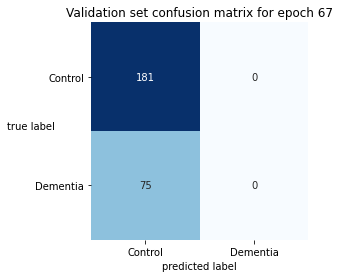

epoch: 68, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.5618, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 69/110
current lr: 0.014125375446227545


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 69 average loss: 0.4639
>>> Validation set
Sample | raw prediction: tensor([ 1.7528, -1.7153]), prediction: 0, actual: 1


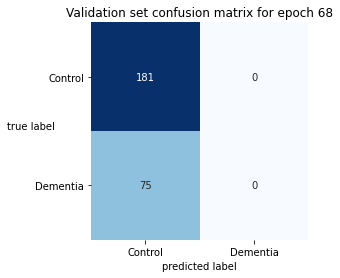

epoch: 69, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7374, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 70/110
current lr: 0.01372460961007562


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 70 average loss: 0.4478
>>> Validation set
Sample | raw prediction: tensor([ 1.9157, -1.8959]), prediction: 0, actual: 1


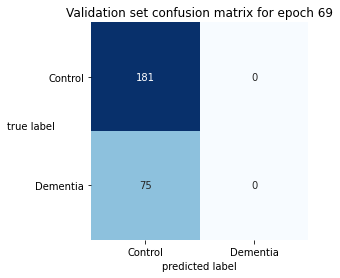

epoch: 70, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4248, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 2.1567, -2.1357]), prediction: 0, actual: 1


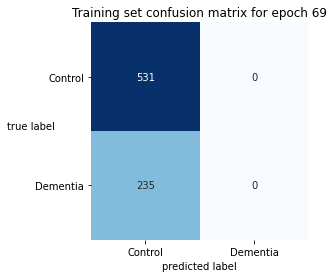

epoch: 70, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.5325, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 71/110
current lr: 0.01333521432163324


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 71 average loss: 0.4518
>>> Validation set
Sample | raw prediction: tensor([ 2.2068, -2.1824]), prediction: 0, actual: 1


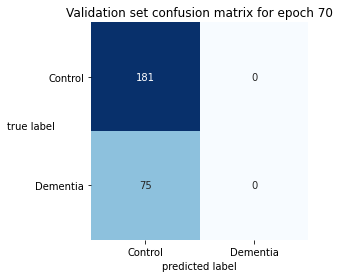

epoch: 71, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3699, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 72/110
current lr: 0.012956866975170199


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 72 average loss: 0.4416
>>> Validation set
Sample | raw prediction: tensor([ 2.6512, -2.6155]), prediction: 0, actual: 1


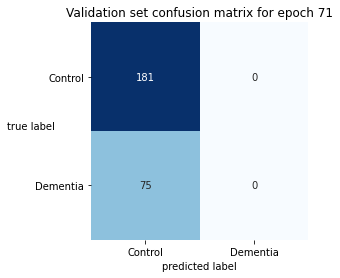

epoch: 72, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3507, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 73/110
current lr: 0.012589254117941673


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 73 average loss: 0.4549
>>> Validation set
Sample | raw prediction: tensor([ 1.7574, -1.7418]), prediction: 0, actual: 1


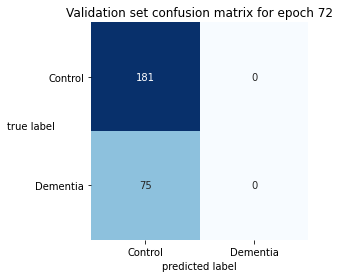

epoch: 73, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7678, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 74/110
current lr: 0.012232071190499317


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 74 average loss: 0.4366
>>> Validation set
Sample | raw prediction: tensor([ 2.8188, -2.7735]), prediction: 0, actual: 1


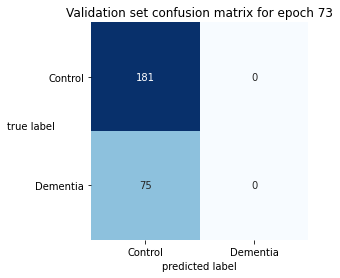

epoch: 74, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7744, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 75/110
current lr: 0.011885022274370185


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 75 average loss: 0.4454
>>> Validation set
Sample | raw prediction: tensor([ 1.9358, -1.9325]), prediction: 0, actual: 1


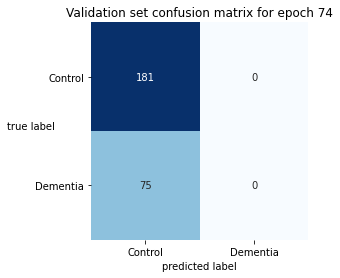

epoch: 75, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3768, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 2.1889, -2.1872]), prediction: 0, actual: 1


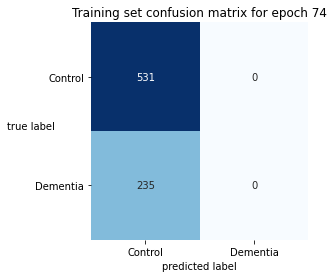

epoch: 75, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.4454, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 76/110
current lr: 0.011547819846894583


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 76 average loss: 0.4366
>>> Validation set
Sample | raw prediction: tensor([ 1.7407, -1.7365]), prediction: 0, actual: 1


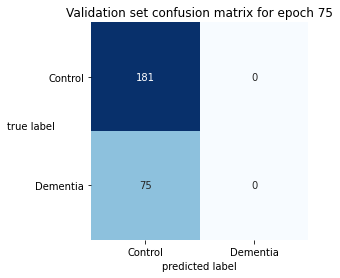

epoch: 76, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3673, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 77/110
current lr: 0.011220184543019637


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 77 average loss: 0.4470
>>> Validation set
Sample | raw prediction: tensor([ 2.3282, -2.3148]), prediction: 0, actual: 1


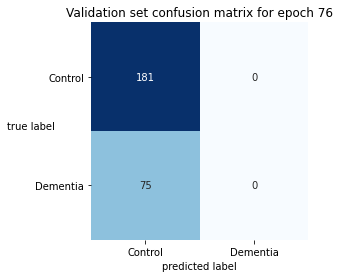

epoch: 77, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4681, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 78/110
current lr: 0.010901844923851278


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 78 average loss: 0.4272
>>> Validation set
Sample | raw prediction: tensor([ 2.5398, -2.5492]), prediction: 0, actual: 1


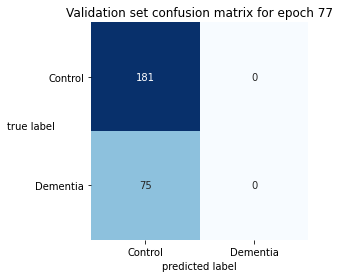

epoch: 78, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.2949, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 79/110
current lr: 0.010592537251772892


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 79 average loss: 0.4540
>>> Validation set
Sample | raw prediction: tensor([ 2.4237, -2.4137]), prediction: 0, actual: 1


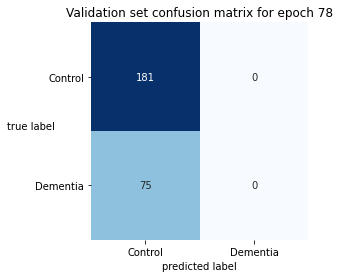

epoch: 79, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3579, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 80/110
current lr: 0.010292005271944281


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 80 average loss: 0.4071
>>> Validation set
Sample | raw prediction: tensor([ 2.5708, -2.5396]), prediction: 0, actual: 1


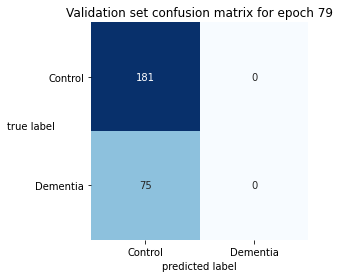

epoch: 80, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7682, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 2.3577, -2.3358]), prediction: 0, actual: 1


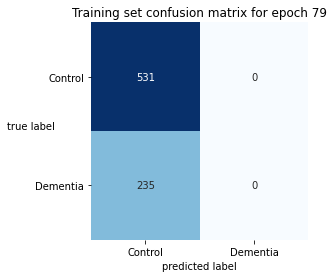

epoch: 80, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7531, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 81/110
current lr: 0.010000000000000002


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 81 average loss: 0.4196
>>> Validation set
Sample | raw prediction: tensor([ 2.7005, -2.6940]), prediction: 0, actual: 1


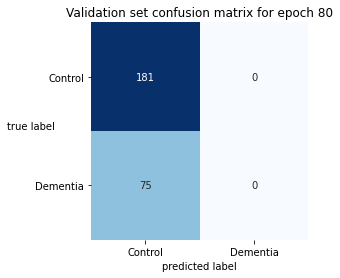

epoch: 81, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4956, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 82/110
current lr: 0.009716279515771064


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 82 average loss: 0.4085
>>> Validation set
Sample | raw prediction: tensor([ 2.8511, -2.8406]), prediction: 0, actual: 1


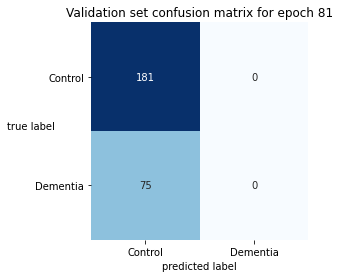

epoch: 82, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3606, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 83/110
current lr: 0.009440608762859237


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 83 average loss: 0.4279
>>> Validation set
Sample | raw prediction: tensor([ 3.0346, -3.0277]), prediction: 0, actual: 1


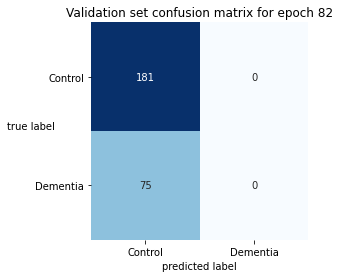

epoch: 83, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4793, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 84/110
current lr: 0.009172759353897794


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 84 average loss: 0.4128
>>> Validation set
Sample | raw prediction: tensor([ 2.2634, -2.2797]), prediction: 0, actual: 1


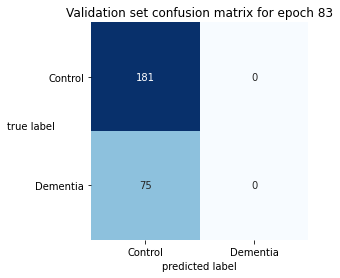

epoch: 84, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3550, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 85/110
current lr: 0.008912509381337455


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 85 average loss: 0.4131
>>> Validation set
Sample | raw prediction: tensor([ 3.4307, -3.4373]), prediction: 0, actual: 1


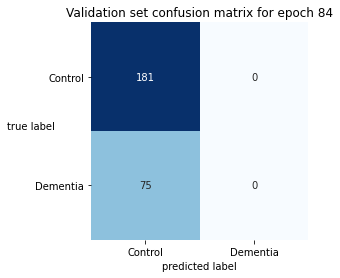

epoch: 85, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.2574, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 3.7474, -3.7498]), prediction: 0, actual: 1


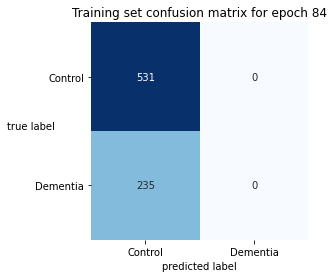

epoch: 85, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.3315, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 86/110
current lr: 0.008659643233600654


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 86 average loss: 0.4046
>>> Validation set
Sample | raw prediction: tensor([ 2.9542, -2.9239]), prediction: 0, actual: 1


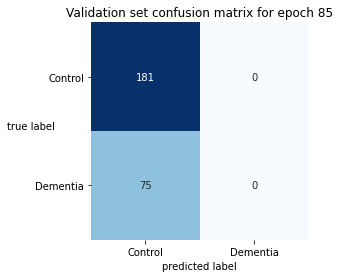

epoch: 86, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6917, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 87/110
current lr: 0.008413951416451952


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 87 average loss: 0.3878
>>> Validation set
Sample | raw prediction: tensor([ 3.6177, -3.6252]), prediction: 0, actual: 1


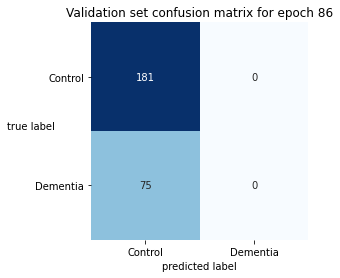

epoch: 87, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4927, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 88/110
current lr: 0.008175230379436502


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 88 average loss: 0.3925
>>> Validation set
Sample | raw prediction: tensor([ 2.9474, -2.9617]), prediction: 0, actual: 1


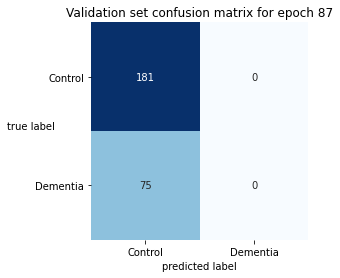

epoch: 88, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3003, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 89/110
current lr: 0.007943282347242814


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 89 average loss: 0.3908
>>> Validation set
Sample | raw prediction: tensor([ 2.6954, -2.6808]), prediction: 0, actual: 1


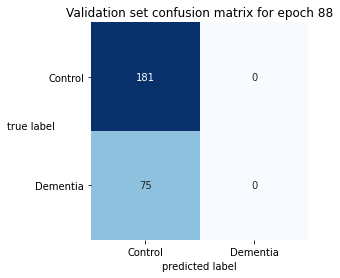

epoch: 89, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7229, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 90/110
current lr: 0.007717915155850123


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 90 average loss: 0.3762
>>> Validation set
Sample | raw prediction: tensor([ 2.7192, -2.7069]), prediction: 0, actual: 1


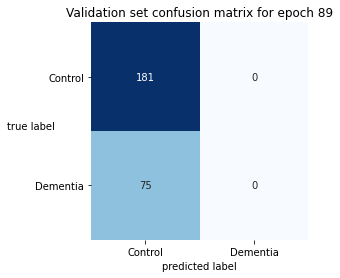

epoch: 90, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6103, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 2.8807, -2.8768]), prediction: 0, actual: 1


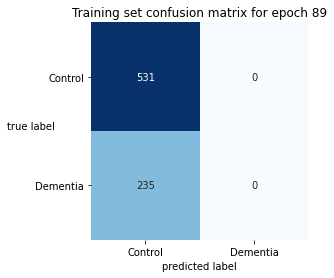

epoch: 90, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7014, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 91/110
current lr: 0.00749894209332456


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 91 average loss: 0.3534
>>> Validation set
Sample | raw prediction: tensor([ 4.3174, -4.3210]), prediction: 0, actual: 1


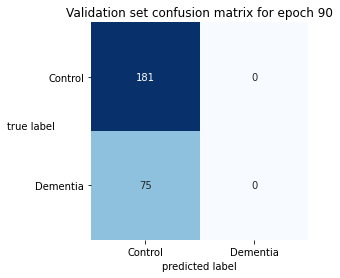

epoch: 91, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.2767, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 92/110
current lr: 0.007286181745132278


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 92 average loss: 0.3970
>>> Validation set
Sample | raw prediction: tensor([ 2.8959, -2.8655]), prediction: 0, actual: 1


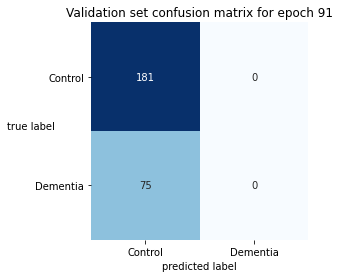

epoch: 92, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.5826, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 93/110
current lr: 0.007079457843841382


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 93 average loss: 0.3722
>>> Validation set
Sample | raw prediction: tensor([ 3.1725, -3.1405]), prediction: 0, actual: 1


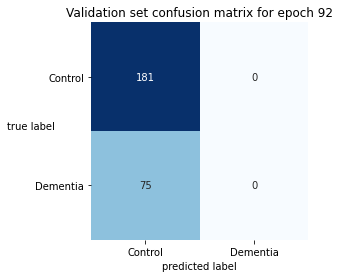

epoch: 93, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.5456, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 94/110
current lr: 0.006878599123088075


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 94 average loss: 0.3494
>>> Validation set
Sample | raw prediction: tensor([ 3.7258, -3.7162]), prediction: 0, actual: 1


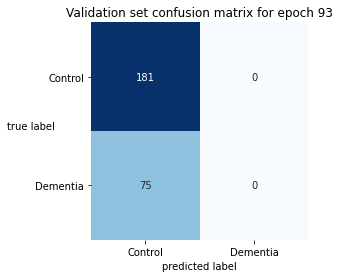

epoch: 94, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6687, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 95/110
current lr: 0.0066834391756861455


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 95 average loss: 0.3705
>>> Validation set
Sample | raw prediction: tensor([ 3.9829, -3.9680]), prediction: 0, actual: 1


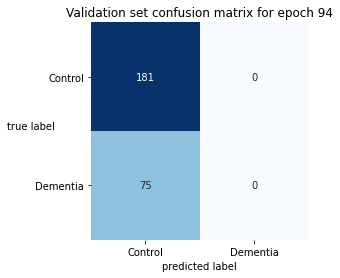

epoch: 95, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3650, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 4.0851, -4.0617]), prediction: 0, actual: 1


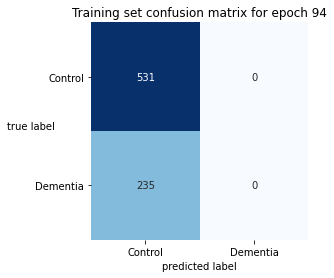

epoch: 95, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.4647, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 96/110
current lr: 0.006493816315762114


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 96 average loss: 0.3690
>>> Validation set
Sample | raw prediction: tensor([ 3.5179, -3.5058]), prediction: 0, actual: 1


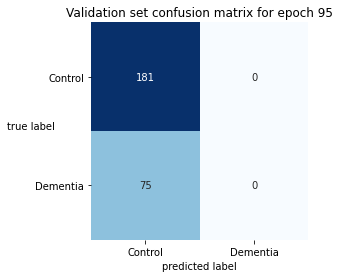

epoch: 96, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4918, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 97/110
current lr: 0.006309573444801934


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 97 average loss: 0.3819
>>> Validation set
Sample | raw prediction: tensor([ 4.5906, -4.6167]), prediction: 0, actual: 1


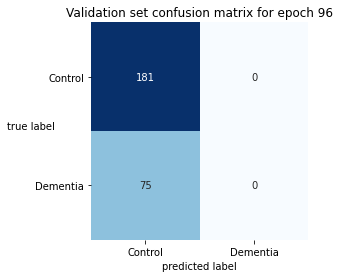

epoch: 97, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6384, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 98/110
current lr: 0.006130557921498209


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 98 average loss: 0.3804
>>> Validation set
Sample | raw prediction: tensor([ 3.7092, -3.7036]), prediction: 0, actual: 1


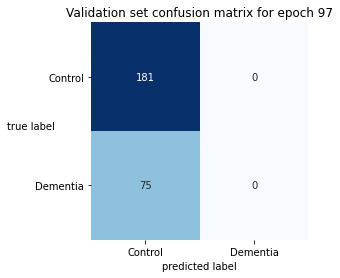

epoch: 98, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6298, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 99/110
current lr: 0.005956621435290105


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 99 average loss: 0.3459
>>> Validation set
Sample | raw prediction: tensor([ 3.4555, -3.4106]), prediction: 0, actual: 1


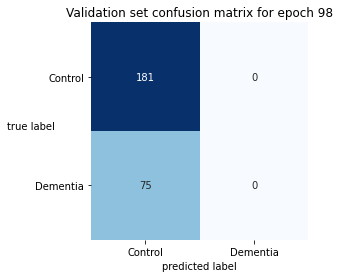

epoch: 99, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7937, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 100/110
current lr: 0.005787619883491206


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 100 average loss: 0.3486
>>> Validation set
Sample | raw prediction: tensor([ 3.2335, -3.1885]), prediction: 0, actual: 1


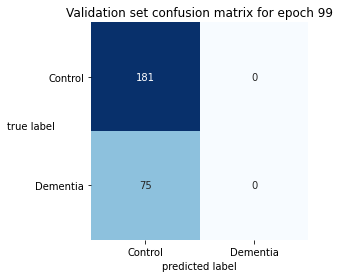

epoch: 100, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.7822, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 3.2054, -3.1558]), prediction: 0, actual: 1


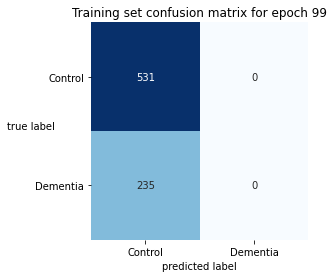

epoch: 100, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7961, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 101/110
current lr: 0.005623413251903492


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 101 average loss: 0.3419
>>> Validation set
Sample | raw prediction: tensor([ 3.3537, -3.3289]), prediction: 0, actual: 1


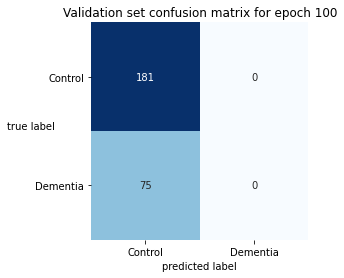

epoch: 101, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6180, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 102/110
current lr: 0.005463865498818544


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 102 average loss: 0.3461
>>> Validation set
Sample | raw prediction: tensor([ 4.6878, -4.6635]), prediction: 0, actual: 1


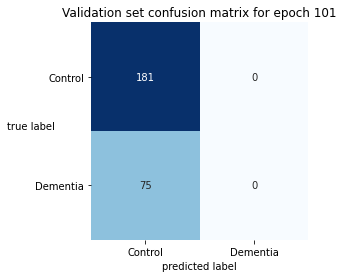

epoch: 102, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4796, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 103/110
current lr: 0.005308844442309886


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 103 average loss: 0.3432
>>> Validation set
Sample | raw prediction: tensor([ 3.8478, -3.8448]), prediction: 0, actual: 1


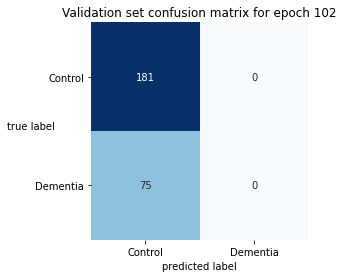

epoch: 103, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.2439, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 104/110
current lr: 0.005158221650723056


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 104 average loss: 0.3247
>>> Validation set
Sample | raw prediction: tensor([ 3.9630, -3.9158]), prediction: 0, actual: 1


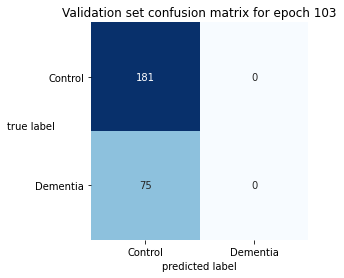

epoch: 104, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6602, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 105/110
current lr: 0.005011872336272723


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 105 average loss: 0.3055
>>> Validation set
Sample | raw prediction: tensor([ 4.6371, -4.6379]), prediction: 0, actual: 1


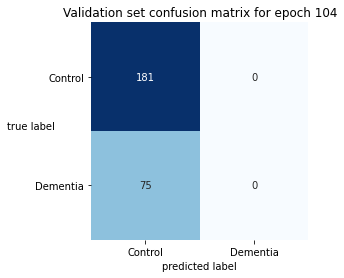

epoch: 105, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6298, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 4.9695, -4.9547]), prediction: 0, actual: 1


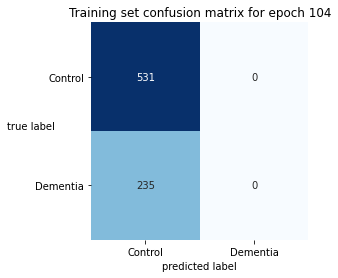

epoch: 105, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.7161, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 106/110
current lr: 0.004869675251658632


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 106 average loss: 0.2958
>>> Validation set
Sample | raw prediction: tensor([ 4.5401, -4.5518]), prediction: 0, actual: 1


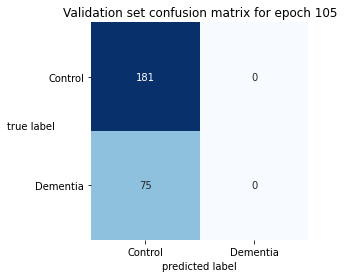

epoch: 106, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3580, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 107/110
current lr: 0.004731512589614806


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 107 average loss: 0.3269
>>> Validation set
Sample | raw prediction: tensor([ 5.2238, -5.1900]), prediction: 0, actual: 1


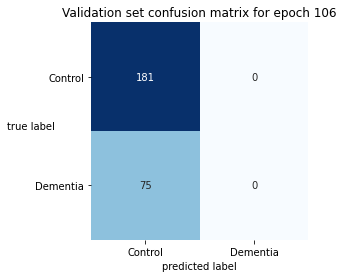

epoch: 107, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3704, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 108/110
current lr: 0.004597269885308723


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 108 average loss: 0.2950
>>> Validation set
Sample | raw prediction: tensor([ 4.7630, -4.7531]), prediction: 0, actual: 1


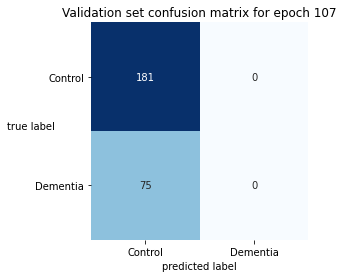

epoch: 108, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.3499, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 109/110
current lr: 0.0044668359215096305


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 109 average loss: 0.2487
>>> Validation set
Sample | raw prediction: tensor([ 4.7593, -4.7592]), prediction: 0, actual: 1


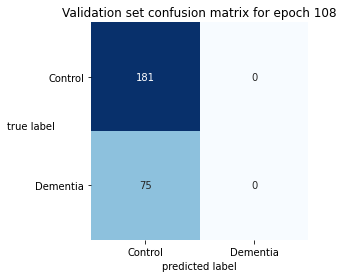

epoch: 109, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.6161, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
----------
epoch 110/110
current lr: 0.004340102636447438


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 110 average loss: 0.2608
>>> Validation set
Sample | raw prediction: tensor([ 4.2655, -4.2367]), prediction: 0, actual: 1


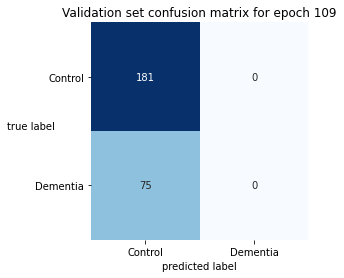

epoch: 110, accuracy: 0.7070, balanced_acc: 0.5000, AUC: 0.4253, precision: 0.0000, recall: 0.0000
>>> Train set
Sample | raw prediction: tensor([ 4.2312, -4.1966]), prediction: 0, actual: 1


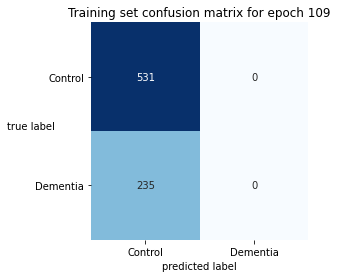

epoch: 110, accuracy: 0.6932, balanced_acc: 0.5000, AUC: 0.6171, precision: 0.0000, recall: 0.0000
best epoch: 10, best accuracy: 0.732817679558011
train completed, best_metric: 0.7328 at epoch: 10


In [21]:
# start a typical PyTorch training
val_interval = 1
train_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
n_epochs = FLAGS.epochs

for epoch in tqdm(range(n_epochs), desc='Epochs'):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{n_epochs}")
    
    # Learning rate decay
    lr_scheduler(optimizer, epoch, lr_decay=0.1)
    curr_lr = optimizer.param_groups[0]['lr']
    print(f'current lr: {curr_lr}')
    
    # Tell the model to go into training mode
    model.train()
    
    epoch_loss = 0
    step = 0
    
    # Loop through batch data
    for batch_data in tqdm(train_loader, file=sys.stdout):
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}", end='\r')
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    # Print stats for validation set
    if (epoch + 1) % val_interval == 0:
        print(">>> Validation set")
        model.eval()
        y, y_pred = get_test_predicted(device, model, val_loader)
        model.train()
        
        y_pred = y_pred.cpu()
        y = y.cpu()
            
        predictions = y_pred.argmax(dim=1)
        print(f'Sample | raw prediction: {y_pred[12]}, prediction: {predictions[12]}, actual: {y[12]}')

        # Calculate metrics

        # Accuracy
        acc = accuracy_score(y, predictions)
        balanced_acc = balanced_accuracy_score(y, predictions)
        # Check if accuracy is better
        if balanced_acc > best_metric:
            best_metric = balanced_acc
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_dict.pth")
            print("saved new best metric model")
        writer.add_scalar("val_accuracy", acc, epoch + 1)
        writer.add_scalar("val_balanced_accuracy", balanced_acc, epoch + 1)

        # ROC-AUC
        y_onehot = [post_label(i) for i in decollate_batch(y)]
        y_pred_act = [post_pred(i) for i in decollate_batch(y_pred)]
        auc_metric(y_pred_act, y_onehot)
        auc_result = auc_metric.aggregate()
        auc_metric.reset()
        del y_pred_act, y_onehot

        # Precision
        precision = 0
        if 1 in predictions:
            precision = precision_score(y, predictions)
        writer.add_scalar("val_precision", precision, epoch + 1)

        # Recall
        recall = recall_score(y, predictions)
        writer.add_scalar("val_recall", recall, epoch + 1)

        # Confusion matrix
        cm = confusion_matrix(y, predictions)

        fig, ax = plt.subplots()
        sns.heatmap(cm, ax=ax, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
        ax.set_xlabel('predicted label')
        ax.set_ylabel('true label', rotation=0)
        ax.set_xticklabels(['Control', 'Dementia'], rotation=0)
        ax.set_yticklabels(['Control', 'Dementia'], rotation=0)
        ax.set_title(f'Validation set confusion matrix for epoch {epoch}')
        plt.show()

        print(f"epoch: {epoch+1}, accuracy: {acc:.4f}, balanced_acc: {balanced_acc:.4f}, AUC: {auc_result:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")
    
    # Print stats for training set
    if (epoch + 1) % train_interval == 0:
        print(">>> Train set")
        model.eval()
        y, y_pred = get_test_predicted(device, model, test_train_loader)
        model.train()
        
        y_pred = y_pred.cpu()
        y = y.cpu()
            
        predictions = y_pred.argmax(dim=1)
        print(f'Sample | raw prediction: {y_pred[12]}, prediction: {predictions[12]}, actual: {y[12]}')

        # Calculate metrics

        # Accuracy
        acc = accuracy_score(y, predictions)
        balanced_acc = balanced_accuracy_score(y, predictions)
        writer.add_scalar("train_accuracy", acc, epoch + 1)
        writer.add_scalar("train_balanced_accuracy", balanced_acc, epoch + 1)

        # ROC-AUC
        y_onehot = [post_label(i) for i in decollate_batch(y)]
        y_pred_act = [post_pred(i) for i in decollate_batch(y_pred)]
        auc_metric(y_pred_act, y_onehot)
        auc_result = auc_metric.aggregate()
        auc_metric.reset()
        del y_pred_act, y_onehot

        # Precision
        precision = 0
        if 1 in predictions:
            precision = precision_score(y, predictions)
        writer.add_scalar("train_precision", precision, epoch + 1)

        # Recall
        recall = recall_score(y, predictions)
        writer.add_scalar("train_recall", recall, epoch + 1)

        # Confusion matrix
        cm = confusion_matrix(y, predictions)

        fig, ax = plt.subplots()
        sns.heatmap(cm, ax=ax, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
        ax.set_xlabel('predicted label')
        ax.set_ylabel('true label', rotation=0)
        ax.set_xticklabels(['Control', 'Dementia'], rotation=0)
        ax.set_yticklabels(['Control', 'Dementia'], rotation=0)
        ax.set_title(f'Training set confusion matrix for epoch {epoch}')
        plt.show()

        print(f"epoch: {epoch+1}, accuracy: {acc:.4f}, balanced_acc: {balanced_acc:.4f}, AUC: {auc_result:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")
        
    print(f"best epoch: {best_metric_epoch}, best accuracy: {best_metric}")

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()